# Data Structure Overview

## The `my_spectra` Array

The `my_spectra` array contains all the spectra loaded from the file.

### Array Structure
Each element in the array follows this format:
```
[mzs, intensities, coordinates]
```

### Component Descriptions

- **`mzs`**: An array of recorded m/z values for that pixel
- **`intensities`**: An array of recorded intensities corresponding to the m/z values for that pixel  
- **`coordinates`**: A tuple in the form `(x, y, z)` where `z=1` for all pixels

### Key Points
- Each spectrum corresponds to a specific spatial location
- The x,y coordinates allow mapping spectra to their physical positions

In [28]:
from pyimzml.ImzMLParser import ImzMLParser
import numpy as np
import random


p = ImzMLParser('../HIV.imzml')
my_spectra = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y, z)])

print(f"Total spectra loaded: {len(my_spectra)}")

    

Total spectra loaded: 56678


In [29]:
from scipy.interpolate import interp1d

# Find global max intensity across all spectra
global_max = 0
all_mzs = []

for spectrum in my_spectra:
    mzs, intensities, _ = spectrum
    global_max = max(global_max, np.max(intensities))
    all_mzs.extend(mzs)

print(f"Global max intensity: {global_max}")

# Create common m/z grid
min_mz, max_mz = min(all_mzs), max(all_mzs)
target_length = 10000  # Adjust as needed
common_mzs = np.linspace(min_mz, max_mz, target_length)

print(f"Common m/z range: {min_mz:.2f} to {max_mz:.2f} with {target_length} points")

# Process each spectrum: normalize with global max and interpolate
processed_spectra = []

for spectrum in my_spectra:
    mzs, intensities, coords = spectrum
    
    # Global normalization
    normalized_intensities = intensities / global_max
    
    # Interpolate to common m/z grid
    interpolator = interp1d(mzs, normalized_intensities, kind='linear', 
                           bounds_error=False, fill_value=0)
    interpolated_intensities = interpolator(common_mzs)
    
    # Store processed spectrum
    processed_spectra.append([common_mzs, interpolated_intensities, coords])

print(f"Processed {len(processed_spectra)} spectra")
print(f"Each spectrum now has {len(common_mzs)} m/z points")

# Verify all spectra have same dimensions
mz_lengths = [len(spectrum[0]) for spectrum in processed_spectra]
intensity_lengths = [len(spectrum[1]) for spectrum in processed_spectra]

print(f"All m/z arrays have same length: {len(set(mz_lengths)) == 1}")
print(f"All intensity arrays have same length: {len(set(intensity_lengths)) == 1}")
print(f"Dimension: {mz_lengths[0]} points per spectrum")

Global max intensity: 9275392.0
Common m/z range: 100.00 to 1499.98 with 10000 points
Processed 56678 spectra
Each spectrum now has 10000 m/z points
All m/z arrays have same length: True
All intensity arrays have same length: True
Dimension: 10000 points per spectrum


In [30]:


# To show that different pixels have different number of recorded mz values
# for spectrum in my_spectra[0::500]:
#     print(f'Pixel {spectrum[2][:2]} has recorded mzs',len(spectrum[0]))

**1. The above cell show that there are only 2 relevant coordinates (x,y) since z=1 for each spectrum**

**From this we can conclude that each spectrum can be plotted on a cartesian plane**

**2. We can see that we always have the same number of intensities as m/z ratios**

**With this array, we can plot the 2D graph of intensities vs m/z for a single pixel point**



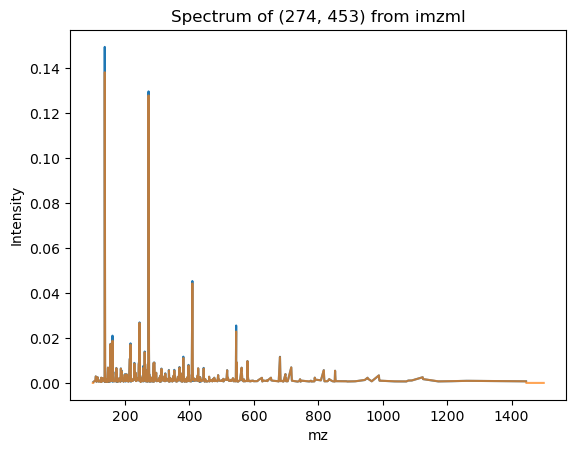

[100.00035858 100.14037068 100.28038278 100.42039487 100.56040697]
[0. 0. 0. 0. 0.]


In [31]:
import matplotlib.pyplot as plt
rand = random.randint(0,len(my_spectra)-1)
spectrumy = my_spectra[rand]
spectrumx = processed_spectra[rand]
# spectrumx = my_spectra[2]
plt.plot(spectrumy[0],spectrumy[1]/global_max)
plt.plot(spectrumx[0],spectrumx[1] ,alpha=0.7)
title = "Spectrum of " + str(spectrumx[2][:2]) + " from imzml"
plt.title(title)
plt.xlabel("mz")
plt.ylabel("Intensity")
plt.show()

print(spectrumx[0][:5])
print(spectrumx[1][:5])


335 460
Points found 56678


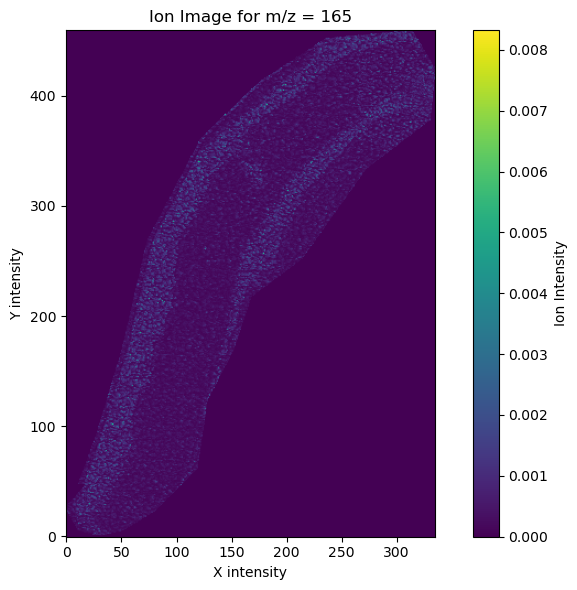

In [39]:

# Choose the m/z you want to plot  and tolerance
target_mz = 165
tolerance = 1

# Get image dimensions
all_coords = [coord for _, _, coord in my_spectra]
xs, ys, _ = zip(*all_coords)
width = max(xs) + 1
height = max(ys) + 1
print(width,height)



# Create empty image
ion_image = np.zeros((height, width))

# Fill in the ion image with intensities for target m/z
times = 0 
for mzs, intensities, (x, y, _) in processed_spectra:
    # Get mask of indices where mz is within target window
    mz_mask = (mzs >= target_mz - tolerance) & (mzs <= target_mz + tolerance)
    if np.any(mz_mask):
        times+=1
        ion_intensity = np.mean(intensities[mz_mask])
        ion_image[y, x] = ion_intensity
print(f"Points found", times)

# Plot the ion image
plt.figure(figsize=(8, 6))
plt.imshow(ion_image, cmap='viridis', origin='lower')
plt.colorbar(label='Ion Intensity')
plt.title(f"Ion Image for m/z = {target_mz}")
plt.xlabel("X intensity")
plt.ylabel("Y intensity")
plt.tight_layout()
plt.show()

In [38]:
processed_spectra[0][0][400:500]

array([156.00519765, 156.14520975, 156.28522185, 156.42523394,
       156.56524604, 156.70525814, 156.84527024, 156.98528234,
       157.12529443, 157.26530653, 157.40531863, 157.54533073,
       157.68534282, 157.82535492, 157.96536702, 158.10537912,
       158.24539121, 158.38540331, 158.52541541, 158.66542751,
       158.80543961, 158.9454517 , 159.0854638 , 159.2254759 ,
       159.365488  , 159.50550009, 159.64551219, 159.78552429,
       159.92553639, 160.06554848, 160.20556058, 160.34557268,
       160.48558478, 160.62559688, 160.76560897, 160.90562107,
       161.04563317, 161.18564527, 161.32565736, 161.46566946,
       161.60568156, 161.74569366, 161.88570575, 162.02571785,
       162.16572995, 162.30574205, 162.44575414, 162.58576624,
       162.72577834, 162.86579044, 163.00580254, 163.14581463,
       163.28582673, 163.42583883, 163.56585093, 163.70586302,
       163.84587512, 163.98588722, 164.12589932, 164.26591141,
       164.40592351, 164.54593561, 164.68594771, 164.82